# 전이학습 
- 고양이 강아지 구분
- VGG16 (2014)
 - 이미지넷으로 사전 훈련된 네트워크를 사용
 - 1000개의 객체를 구분하는 모델이나, 여기서는 고양이, 강아지 구분에 사용  

- 1) 특성추출 방식
 - 합성곱 필터링 영역(convolutional base)를 그대로 사용
 - 공통되는 특성만 추출하여 사용한다
 - 전결합망 부분은 새로운 데이터 (고양이/강아지)로 학습을 다시 시킨다


- 2) 미세 조정 방식


## 데이터 다운로드

In [1]:
import os, os.path, shutil
import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications import VGG16
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## VGG16으로 사전학습된 가중치 가져오기
- include_top은 기존의 1000개 전결합망 분류기를 포함할지를 선택

In [2]:
conv_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 2s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 두가지 옵션이 가능하다
### 1) 합성곱 기반을 통과한 출력을 저장한 후 이를 전결합망에 통과
- 데이터 확장은 사용할 수 없다
- 실행이 빠르다

### 2) 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다


### 1) 방식을 먼저 수행한다.


### 데이터 읽기

In [4]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  99.5M      0 --:--:-- --:--:-- --:--:-- 99.4M


In [5]:
!unzip -q cats_and_dogs_filtered.zip

In [6]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [7]:
train_dir

'./cats_and_dogs_filtered/train'

## 특성추출만 사용한 모델 (데이터 증식은 사용하지 않는 방식)
- ImageDataGenerator를 사용하여 이미지와 레이블을 생성
- conv_base 모델의 predict를 사용하여 이미지의 특성을 추출
- 마지막 출력의 크기가 (4, 4, 512)이다.


In [8]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 

In [ ]:
img_width = 150
img_height = 150
batch_size=20

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory,
 	    target_size=(img_width,img_height),
      class_mode='binary',
			batch_size=batch_size)
  i=1
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size] = features_batch
    labels[i*batch_size:(i+1)*batch_size] = labels_batch
    i += 1
    if i* batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))

    
model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 4,195,329
Trainable params: 4,195,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data= (validation_features, validation_labels),
    batch_size=batch_size)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 527us/step - loss: 0.5418 - acc: 0.7250 - val_loss: 0.4008 - val_acc: 0.8470
Epoch 2/30
2000/2000 [==============================] - 1s 329us/step - loss: 0.3884 - acc: 0.8330 - val_loss: 0.3437 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 1s 327us/step - loss: 0.3232 - acc: 0.8685 - val_loss: 0.3170 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 1s 329us/step - loss: 0.2911 - acc: 0.8900 - val_loss: 0.3032 - val_acc: 0.8770
Epoch 5/30
2000/2000 [==============================] - 1s 327us/step - loss: 0.2610 - acc: 0.8950 - val_loss: 0.2937 - val_acc: 0.8720
Epoch 6/30
2000/2000 [==============================] - 1s 326us/step - loss: 0.2386 - acc: 0.9055 - val_loss: 0.2865 - val_acc: 0.8720
Epoch 7/30
2000/2000 [==============================] - 1s 323us/step - loss: 0.2274 - acc: 0.9160 - val_loss: 0.2804 - val_acc: 0.8830


## 성능 확인

Text(0.5,1,'Training(--) and validation loss')

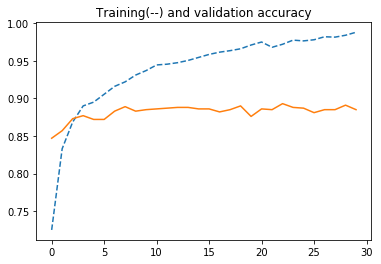

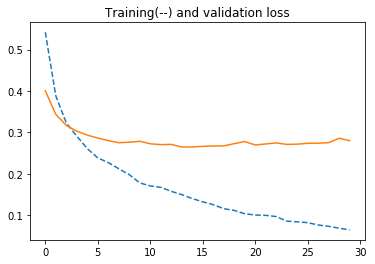

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

### 과대적합이 발생한 것을 알 수 있다.
- 훈련 데이터가 부족하다
- 데이터 확장을 사용하여 개선할 수 있다.

### 2) 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다
- 엔드-투-엔드로 실행한다

In [9]:
# 모델

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


## 학습을 동결하지 않으면 모두 재 학습된다!

In [10]:
conv_base.trainable = False

In [11]:
print(len(model.trainable_weights))

4


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### 컴파일을 수행해야 변경사항이 적용된다

In [15]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True,
  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
											   class_mode='binary',
											   batch_size=20)




NameError: ignored

### 과대적합이 줄어든 것을 볼 수 있다.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])


history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 18s 184ms/step - loss: 0.5978 - acc: 0.7030 - val_loss: 0.4619 - val_acc: 0.8110
Epoch 2/30
100/100 [==============================] - 17s 174ms/step - loss: 0.4917 - acc: 0.7890 - val_loss: 0.3836 - val_acc: 0.8390
Epoch 3/30
100/100 [==============================] - 17s 171ms/step - loss: 0.4399 - acc: 0.8095 - val_loss: 0.3509 - val_acc: 0.8500
Epoch 4/30
100/100 [==============================] - 17s 169ms/step - loss: 0.4062 - acc: 0.8215 - val_loss: 0.3296 - val_acc: 0.8600
Epoch 5/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3875 - acc: 0.8275 - val_loss: 0.3138 - val_acc: 0.8720
Epoch 6/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3755 - acc: 0.8345 - val_loss: 0.3012 - val_acc: 0.8690
Epoch 7/30
100/100 [==============================] - 17s 171ms/step - loss: 0.3634 - acc: 0.8520 - val_loss: 0.2942 - val_acc: 0.8760
Epoch 8/30
100/100 [==============================] - 1

Text(0.5,1,'Training(--) and validation loss')

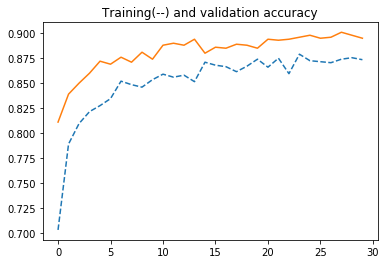

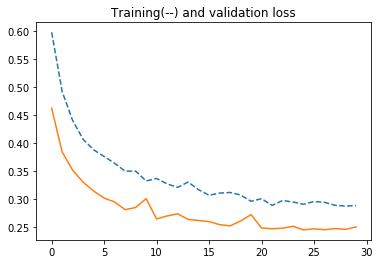

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

## 미세조정 방법
- 상위 계층 몇개를 재학습시킨다
- 앞에서 소개한 절차, 즉, 전결합망(top)부분을 먼저 학습시킨 후에 상위계층의 미세조정을 해야 한다 (한번에 학습하면 안되고 두 단계로 나누어야 함)

         

In [ ]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### 위에서 block 5 부분만 미세조정 하겠다

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

### 학습률을 작게 조정한다 (천천히 학습하도록)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])


history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 19s 188ms/step - loss: 0.2903 - acc: 0.8690 - val_loss: 0.2935 - val_acc: 0.8880
Epoch 2/30
100/100 [==============================] - 18s 178ms/step - loss: 0.2650 - acc: 0.8880 - val_loss: 0.2300 - val_acc: 0.9220
Epoch 3/30
100/100 [==============================] - 17s 174ms/step - loss: 0.2334 - acc: 0.9005 - val_loss: 0.2010 - val_acc: 0.9280
Epoch 4/30
100/100 [==============================] - 18s 178ms/step - loss: 0.2270 - acc: 0.8955 - val_loss: 0.2103 - val_acc: 0.9170
Epoch 5/30
100/100 [==============================] - 18s 179ms/step - loss: 0.2015 - acc: 0.9140 - val_loss: 0.2079 - val_acc: 0.9170
Epoch 6/30
100/100 [==============================] - 18s 176ms/step - loss: 0.1931 - acc: 0.9215 - val_loss: 0.2189 - val_acc: 0.9280
Epoch 7/30
100/100 [==============================] - 17s 173ms/step - loss: 0.1869 - acc: 0.9210 - val_loss: 0.2027 - val_acc: 0.9300
Epoch 8/30
100/100 [==============================] - 1

Text(0.5,1,'Training(--) and validation loss')

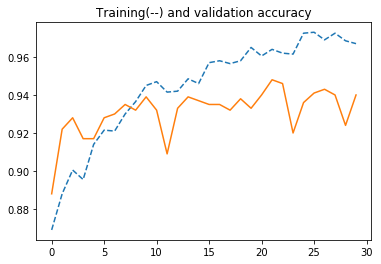

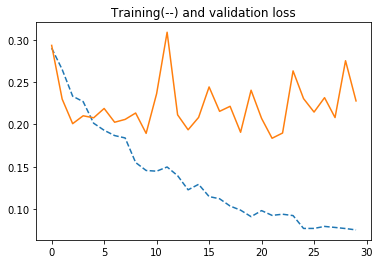

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

## 성능이 92%로 1% 정도 향상되었다.
- 주의 할 것은 손실함수는 향상되지 않는 것으로 나타나도, 성능이 향상될 수 있다는 것이다. (분류 성능은 어떤 임계값만 넘으면 활률적으로 개선될 수 있다)

## 요약
- 과대적합을 줄이기 위해서 데이터 확장을 사용
- 전이학습 중 특성 추출방식 소개
- 전이학습 중 미세조정 방식 소개